<center>
    <img src="http://sct.inf.utfsm.cl/wp-content/uploads/2020/04/logo_di.png" style="width:60%">
    <h1> INF-285 - Computación Científica </h1>
    <h2> An slow root finder (?) </h2>
    <h2> <a href="#acknowledgements"> [S]cientific [C]omputing [T]eam </a> </h2>
    <h2> Version: 1.00 </h2>
</center>



<div id='toc' />

## Table of Contents
* [Introduction](#intro)
* [The test function](#test_function)
* [The first numerical experiment](#FNE)
* [The second numerical experiment](#SNE)
* [The third numerical experiment](#TNE)
* [Conclusion](#conclusion)
* [Acknowledgements](#acknowledgements)

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
sym.init_printing()
import bitstring as bs
import pandas as pd
pd.set_option("display.colheader_justify","center")
pd.options.display.float_format = '{:.10f}'.format

# This function shows the bits used for the sign, exponent and mantissa for a 64-bit double presision number.
# fps: Floating Point Standard
# Double: Double precision IEEE 754
def to_fps_double(f):
    b = bs.pack('>d', f)
    b = b.bin
    #show sign + exponent + mantisa
    print(b[0]+' '+b[1:12]+ ' '+b[12:])
    
from colorama import Fore, Back, Style
# https://pypi.org/project/colorama/
# Fore: BLACK, RED, GREEN, YELLOW, BLUE, MAGENTA, CYAN, WHITE, RESET.
# Back: BLACK, RED, GREEN, YELLOW, BLUE, MAGENTA, CYAN, WHITE, RESET.
# Style: DIM, NORMAL, BRIGHT, RESET_ALL
textBold = lambda x: Style.BRIGHT+x+Style.RESET_ALL
textBoldH = lambda x: Style.BRIGHT+Back.YELLOW+x+Style.RESET_ALL
textBoldB = lambda x: Style.BRIGHT+Back.BLUE+Fore.BLACK+x+Style.RESET_ALL
textBoldR = lambda x: Style.BRIGHT+Back.RED+Fore.BLACK+x+Style.RESET_ALL

<div id='intro' />

# Introduction
[Back to TOC](#toc)

In this jupyter notebook we will study the behaviour of a _ABSRF_ (A Bad and Slow Root Finder).
Notice that we have added "(?)" in the title since we still need to evaluate it in kore detail, basically, we will make a comparison with the bisection method itself.

We will study this root finder because it has been traditionally proposed every time this class has been taught and it is important to quantify its behaviour, this means, to understand how fast it converges to a root and how long it takes.

The algorithm is as follows:
- Consider we have a continuous function $f(x)$ that has a root in the interval $[a,b]$.
- The ABSRF divides the interval in $N$ equalspaced segments and then it finds in which interval there is a change of sign, it then subdivides that interval and continues the procedure.

The algorithm is simple and it will be interesting to analyze it.

In [20]:
'''
INPUT:
a   : (double)  Left end of interval [a,b] where we will find the root.
b   : (double)  Right end of interval [a,b] where we will find the root.
f   : (lambda)  Lambda function that we will find an approximation of a root.
N   : (integer) Number of segments we will be using in each decomposition of the interval.
TOL : (double)  Tolerance for converge we will be using.
flag_OUTPUT : (bool) Flag to show the evolution of the algorithm.
M   : (int) Max number of evaluations allowed.

OUTPUT:
r   : (double)  The approximation found for the root.
m   : (int)     Number of functions evaluations computed.
'''
def ASRF(a,b,f,N=10,TOL=1e-8, flag_OUTPUT=True, M=int(1e2)):
    fa = f(a)
    m  = 1 # Counting the number of evaluations used.
    r  = a
    computed_error = 2*TOL+1
    # Output table to store the numerical evolution of the algorithm
    output_table = []
    
    # If the root is at "a"
    if np.abs((b-a)/2.)<TOL:
        r = a
        return r, m
    # If there is no change of sign
    m = m+1
    if fa*f(b)>=0:
        print('Error: No change of sign')
        return np.nan, m
    
   # N must be at least 3
    if N<2:
        print('Error: N must be at least 2')
        return np.nan, m 
    
    # Counter for the number of lines of output.
    k=0
    # Iterate until the tolerance is reached
    while computed_error > TOL:
        X = np.linspace(a,b,N+1)
        for i, xi in np.ndenumerate(X[1:]):
            # There is key difference respecto to the bisection method at this point,
            # the difference is that in general we need to determine in which interval
            # it is the root, where in the bisection method we know that if it is not
            # in one interval, it must be on the other interval. Of course we need
            # to consider the case when the root is at $x=c$.
            m = m+1
            fxi=f(xi) 
            if fa*fxi<0:
                a = X[i]
                b = xi
                r = (a+b)/2.
                fa = f(a)
                m = m+1
                # Saving the output data
                k=k+1
                output_table.append([k, int(i[0]), a, xi, b, f(a), f(xi), f(b), b-a, r, m])
                break
            elif fxi==0:
                r = xi
                output_table.append([k, int(i[0]), a, xi, b, f(a), f(xi), f(b), b-a, r, m]) 
                if flag_OUTPUT:
                    # Showing final output table
                    columns    = ['$k$', '$i$', '$a$', '$x_i$', '$b$','$f(a)$', '$f(x_i)$', '$f(b)$', '$b-a$', '$r$', '$m$']
                    df = pd.DataFrame(data=output_table, columns=columns)
                    display(df)
                return r, m
            else:
                # Saving the output data
                k = k+1
                output_table.append([k, int(i[0]), a, xi, b, f(a), f(xi), f(b), b-a, r, m])
            if m>=M:
                break 
        computed_error = np.abs((b-a)/2.)
        m=m+1
        if m>=M:
            print('Max number of evaluation allowed has been reached')
            break
    if flag_OUTPUT:
        # Showing final output table
        columns    = ['$k$', '$i$', '$a$', '$x_i$', '$b$','$f(a)$', '$f(x_i)$', '$f(b)$', '$b-a$', '$r$', '$m$']
        df = pd.DataFrame(data=output_table, columns=columns)
        display(df)
    return r, m

The following code is just the implementation of the Bisection method.
We include it here just for comparison purposes.

In [21]:
# This implemenatation of the bisection method was obtained from the
# Jupyter Notebook called '03_roots_of_1D_equations.ipynb', the main difference
# is that in this implementation returns the number of function
# evaluations used.
def bisect(f, a, b, tol=1e-8, maxNumberIterations=100,flag_OUTPUT=True):
    # Evaluating the extreme points of the interval provided
    fa = f(a)
    m = 1 # This variable will be used to count the number of function evaluations
    fb = f(b)
    m = m+1
    # Iteration counter.
    i = 0
    # Just checking if the sign is not negative => not root  necessarily 
    if np.sign(fa*fb) >= 0: # This was updated!
        print('f(a)f(b)<0 not satisfied!')
        return None
  
    # Output table to store the numerical evolution of the algorithm
    output_table = []
    
    # Main loop: it will iterate until it satisfies one of the two criterias:
    # The tolerance 'tol' is achived or the max number of iterations is reached.
    while ((b-a)/2 > tol) and i<=maxNumberIterations:
        # Obtaining the midpoint of the interval. Quick question: What could happen if a different point is used?
        c = (a+b)/2.
        # Evaluating the mid point
        fc = f(c)
        m = m+1
        # Saving the output data
        output_table.append([i, a, c, b, fa, fc, fb, b-a])

        # Did we find the root?
        if fc == 0:
            print('f(c)==0')
            break
        elif np.sign(fa*fc) < 0:
            # This first case consider that the new inetrval is defined by [a,c]
            b = c
            fb = fc
        else:
            # This second case consider that the new interval is defined by [c,b]
            a = c
            fa = fc
        # Increasing the iteration counter
        i += 1
    if flag_OUTPUT: 
        # Showing final output table
        columns    = ['$i$', '$a_i$', '$c_i$', '$b_i$', '$f(a_i)$', '$f(c_i)$', '$f(b_i)$', '$b_i-a_i$']
        df = pd.DataFrame(data=output_table, columns=columns)
        display(df)
    
    # Computing the best approximation obtaind for the root, which is the midpoint of the final interval.
    xc = (a+b)/2.
    return xc, m

<div id='test_function' />

# The test function
[Back to TOC](#toc)

To test the ASRF against the Bisection method, we need to build a function that we can move the location of the root.
To acomplish this, we designed the following function:
$$
\begin{align*}
    f(x,h) &= (x+2\,h)\,(x-h)\\
         &= x^2+h\,x-2\,h^2. 
\end{align*} 
$$
For the numerical experiments, we can simply set value for $h$ between $0$ and $1$ for simplicity.
This will allow us to to have a known interval.
We clearly see that the roots of the polynomial on $x$ are $r_1=-2\,h$ and $r_2=h$,
in particular we will be trying to recover numerically $r_2$.

Notice that we have expanded the polynomial to make it _more interesting_ from the floating point standard point of view.

The following code implements $f(x,h)$ and an auxiliary function $f_2(x)$.

In [22]:
# Testing function f2=(x+2*h)*(x-h). 
# Notice we know it has a root in h and -2*h.
# To make the evaluation 'challenging', 
# we will expand the polynomial.
# The advantage of this test function is that we know in advance
# that it has a root in the interval [0,1] if 0<h<1.
f  = lambda x,h: np.power(x,2)+h*x-2*np.power(h,2)
f2 = lambda x: f(x,np.sqrt(2)/2)

<div id='FNE' />

# The First Numerical Experiment
[Back to TOC](#toc)

The output looks similar to the output generated by the Bisection Method, however in this case we added the index for the internal loop that goes over each interval with the index $i$.


In [23]:
r, m = ASRF(a=0, b=1, f=f2, N=5)
print(r, m)

,$k$,$i$,$a$,$x_i$,$b$,$f(a)$,$f(x_i)$,$f(b)$,$b-a$,$r$,$m$
0,1,0,0.0000000000,0.2000000000,1.0000000000,-1.0000000000,-0.8185786438,0.7071067812,1.0000000000,0.0000000000,3
1,2,1,0.0000000000,0.4000000000,1.0000000000,-1.0000000000,-0.5571572875,0.7071067812,1.0000000000,0.0000000000,4
2,3,2,0.0000000000,0.6000000000,1.0000000000,-1.0000000000,-0.2157359313,0.7071067812,1.0000000000,0.0000000000,5
3,4,3,0.6000000000,0.8000000000,0.8000000000,-0.2157359313,0.2056854249,0.2056854249,0.2000000000,0.7000000000,7
4,5,0,0.6000000000,0.6400000000,0.8000000000,-0.2157359313,-0.1378516600,0.2056854249,0.2000000000,0.7000000000,9
5,6,1,0.6000000000,0.6800000000,0.8000000000,-0.2157359313,-0.0567673888,0.2056854249,0.2000000000,0.7000000000,10
6,7,2,0.6800000000,0.7200000000,0.7200000000,-0.0567673888,0.0275168825,0.0275168825,0.0400000000,0.7000000000,12
7,8,0,0.6800000000,0.6880000000,0.7200000000,-0.0567673888,-0.0401665345,0.0275168825,0.0400000000,0.7000000000,14
8,9,1,0.6800000000,0.6960000000,0.7200000000,-0.0567673888,-0.0234376803,0.0275168825,0.0400000000,0.7000000000,15
9,10,2,0.6800000000,0.7040000000,0.7200000000,-0.0567673888,-0.0065808260,0.0275168825,0.0400000000,0.7000000000,16


0.7071067811839999 69


<div id='SNE' />

# The Second Numerical Experiment
[Back to TOC](#toc)

This second numerical experiments computed the number of function evaluation required to obtain the root of $f_2(x)$ as we change the number of intervals used.
Notice that when $N=2$ you may think we should actually get back the bisection method, but we, unfortunately, don't.

In particular, it seems that using $N=8$ we get the best performance, which is $56$ function evaluations.

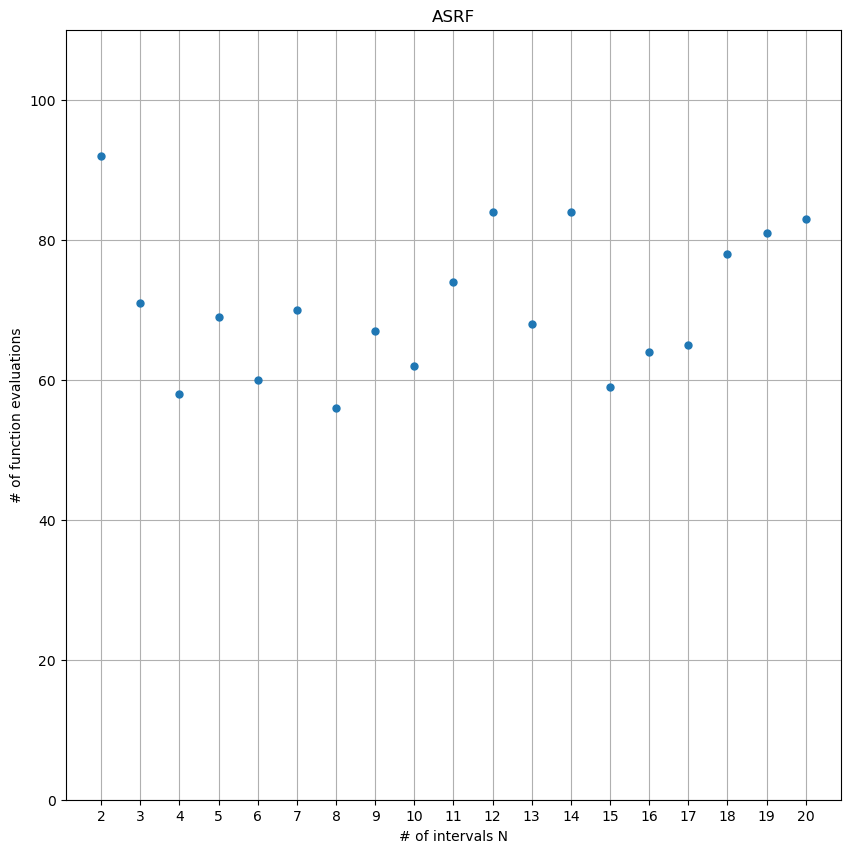

In [24]:
data_number_of_function_evaluations = []
# The range of intervals to be used
Ns = np.arange(2,21)
for N in Ns:
    r, m = ASRF(a=0, b=1, f=f2, N=N, flag_OUTPUT=False)
    data_number_of_function_evaluations.append(m)
plt.figure(figsize=(10,10))
plt.plot(Ns,data_number_of_function_evaluations,'.', markersize=10)
plt.title('ASRF')
plt.xticks(Ns)
plt.xlabel('# of intervals N')
plt.ylabel('# of function evaluations')
plt.grid(True)
plt.ylim([0, 110])
plt.show()

<div id='TNE' />

# The Third Numerical Experiment
[Back to TOC](#toc)

This last numerical experiment is the largest case, we test the ASRF method against the Bisection method.
We select the range from $2$ up to $20$ intervals and we selected $12$ roots equalspaced from $h=0.12$ up to $0.92$,
this may seem like arbitrary numbers and they are, so we invite you to try with different number, but just remember that if you change the range, you must change the values for $a$ and $b$ accordingly.

In [25]:
# Range of number of intervals used, starting from 2.
Ns = np.arange(2,21)
# Range of roots tested.
Hs = np.linspace(0.12,0.92,12)

# Running ASRF numerical experiments.
all_output_ASRF = []
for h in Hs:
    print('Running numerical experiment with h=',h)
    output_ASRF= [] 
    for N in Ns:
        rN, m = ASRF(a=0, b=1, f=lambda x: f(x,h), N=N, flag_OUTPUT=False)
        output_ASRF.append(m)
    all_output_ASRF.append(output_ASRF)
    
# Running Bisection method experiments.
out_bisection = []
for h in Hs:
    r, m = bisect(f=lambda x: f(x,h), a=0, b=1,flag_OUTPUT=False)
    out_bisection.append(m)

Running numerical experiment with h= 0.12
Max number of evaluation allowed has been reached
Running numerical experiment with h= 0.19272727272727275
Running numerical experiment with h= 0.2654545454545455
Running numerical experiment with h= 0.3381818181818182
Running numerical experiment with h= 0.41090909090909095
Running numerical experiment with h= 0.4836363636363637
Running numerical experiment with h= 0.5563636363636364
Running numerical experiment with h= 0.6290909090909091
Running numerical experiment with h= 0.7018181818181819
Running numerical experiment with h= 0.7745454545454546
Running numerical experiment with h= 0.8472727272727274
Max number of evaluation allowed has been reached
Running numerical experiment with h= 0.92


## Fist large plot

This first large plots show in color the behavior of ASRF as we change the number of intervals for each the $12$ values of $h$ described before.
We show in a red dashed line the maximum number of function evaluation allowed and in a thick black line the mean value of the function evaluation for each number of intervals.
This plot tells us that, on average, it seems that using $5$ intervals may be the most competitive value for the number of intervals. 

Will this be better than the output (number of function evaluation) obtain by the Bisection method?
To answer this question we need to change the plot, but using the same data.
If we try to plot the output of the bisection method in this figure, it may not be fair since the bisection method does not depend on the number of intervals, since it always uses 2 intervals.
To solve this problem, we change the way we plot the results in the next plot.

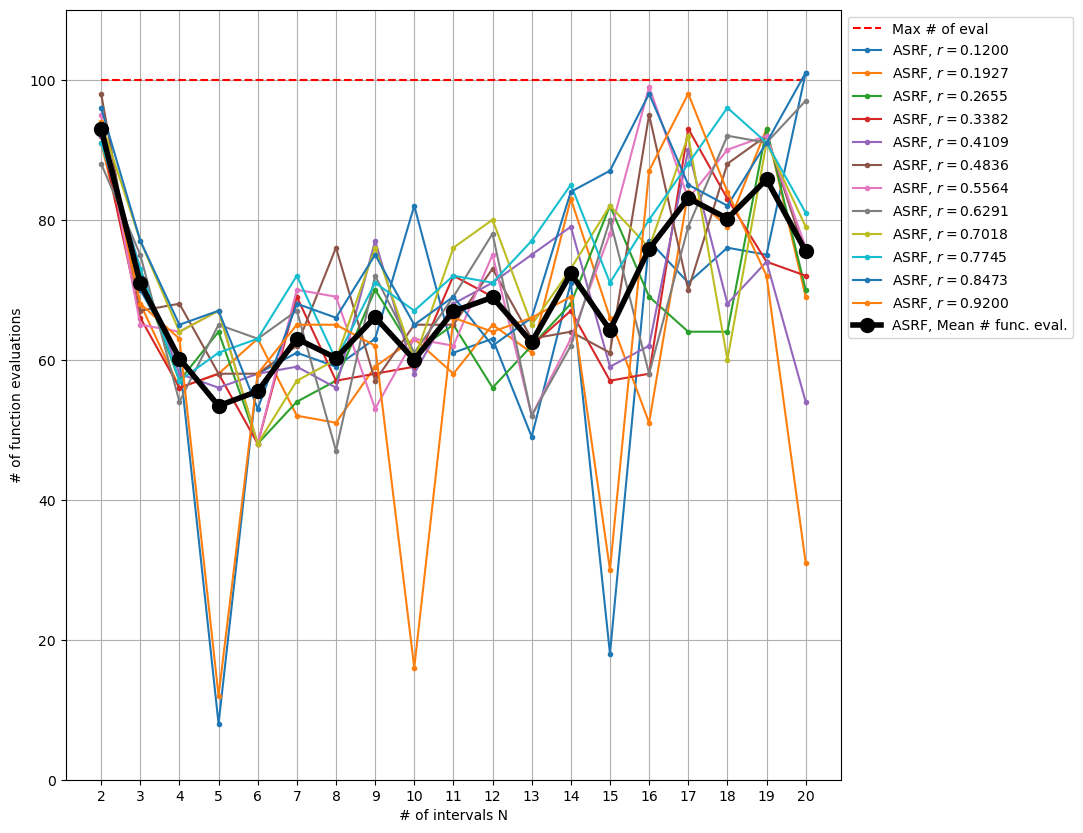

In [26]:
plt.figure(figsize=(10,10))
plt.plot(Ns,Ns*0+100,'r--',label="Max # of eval")
for output_ASRF, h in zip(all_output_ASRF,Hs): 
    plt.plot(Ns,output_ASRF,'.-',label=r"ASRF, $r=%.4f$"%(h))
plt.plot(Ns,np.mean(np.array(all_output_ASRF),0),'.-k',linewidth=4,label='ASRF, Mean # func. eval.', markersize=20)
plt.xlabel('# of intervals N')
plt.xticks(Ns)
plt.ylabel('# of function evaluations')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.grid(True)
plt.ylim([0,110])
plt.show()

## Second large plot

In this case, we plot the behavior of the algorithm as a function of the root we are looking for.
The behavior of the different number of intervals is considered with different colors over the set of roots.
Now it is possible to add the Bisection method in cyan with large square markers.
The behavior of the Bisection method is constant, as expected.

A reasonable question that you may have by looking at this plot is the following:
- Why ASRF seems better than the Bisection method for the first and last root?

(The answer is left as an exercise!)

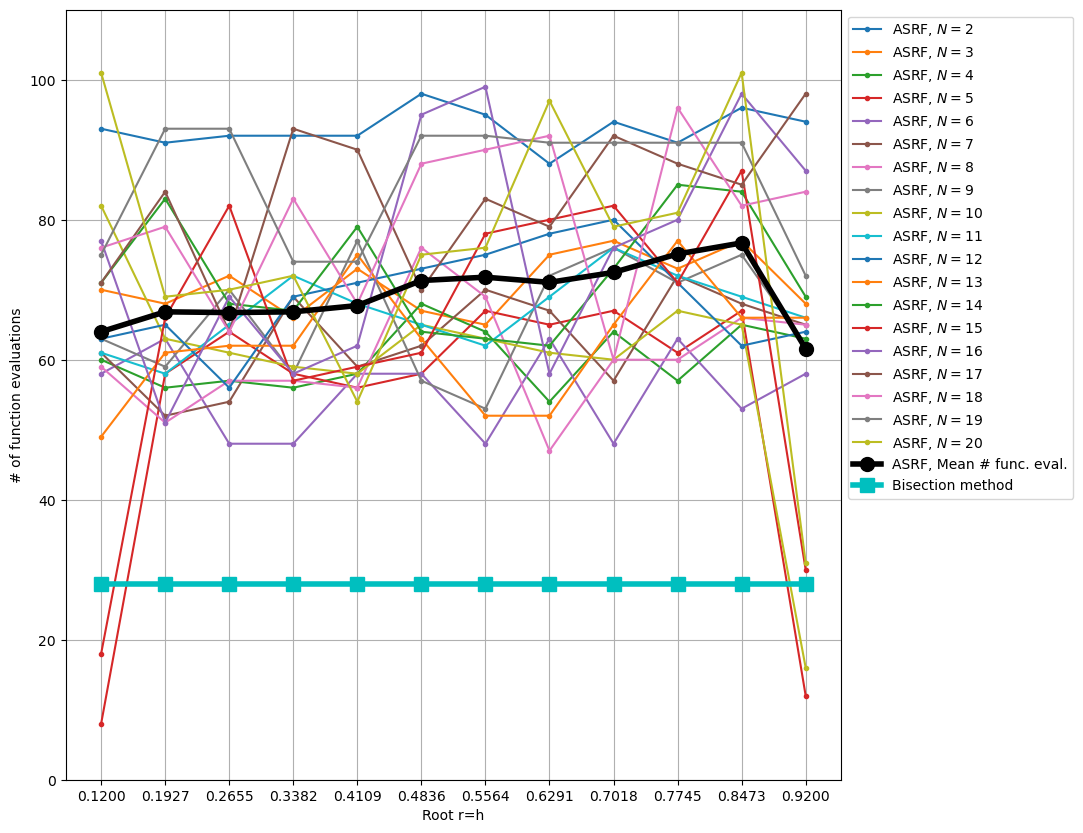

In [27]:
plt.figure(figsize=(10,10))
#plt.plot(Ns,Ns*0+100,'r--',label="Max # of eval")
output_ASRF = np.array(all_output_ASRF)
for output_Hs, N in zip(output_ASRF.T,Ns): 
    plt.plot(Hs,output_Hs,'.-',label=r"ASRF, $N=%d$"%(N))
plt.plot(Hs,np.mean(np.array(output_ASRF),1),'.-k',linewidth=4,label='ASRF, Mean # func. eval.', markersize=20)
plt.plot(Hs, out_bisection,'cs-',label='Bisection method', markersize=10, linewidth=4)
plt.xlabel('Root r=h')
plt.xticks(Hs)
plt.ylabel('# of function evaluations')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.ylim([0,110])
plt.grid(True)
plt.show()

<div id='conclusion' />

# Conclusion
[Back to TOC](#toc)

We have successfully study and implemented the ASRF method, and we have also compare it with the Bisection method.
The main conclusion is that the Bisection method is clearly a more stable method but there may be cases where ASRF may be better, the problem is that it is not clear what are the conditions when this happens.

Quick questions: 
- What about if we don't use the midpoint in the bisection method? Can we extend this study to evaluate this?
- Why did we compare the number of function evaluations instead the computation time requiered?

<div id='acknowledgements' />

# Acknowledgements
[Back to TOC](#toc)

* _Material originally created by professor Claudio Torres_ (`ctorres@inf.utfsm.cl`). v.1.0. DI UTFSM. April 2022._